# Project One - Visualizations


In [48]:
# Dependencies
import pandas as pd
import requests
import json
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Google API Key
from config import gkey


In [49]:
# Source files
visitors = 'Resources/Clean/Clean_ParkData.xlsx'
park_info = 'Resources/Clean/Clean_ParkGeocoordinates.xlsx'
state_orders = 'Resources/Clean/Clean_EmergencyOrders.xlsx'
wildfires = 'Resources/Raw/2020wildfires.xlsx'
yoy_summary = 'Resources/Clean/Clean_YOY_MonthlyVisitors.xlsx'

# Read data and store in dataframe
attendance_data = pd.read_excel(visitors)
park_info_data = pd.read_excel(park_info)
emergency_orders_data = pd.read_excel(state_orders)
wildfire_data = pd.read_excel(wildfires)


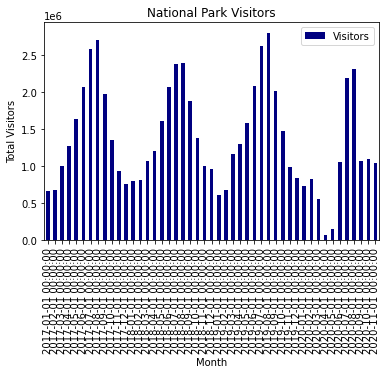

In [50]:
# Generate a bar plot for visitors by month 
visitors_group = attendance_data.groupby('Month')
measures = pd.DataFrame(visitors_group['Visitors'].sum())

visitors_chart=measures.plot(kind='bar', title='National Park Visitors', color='navy')

visitors_chart.set_xlabel('Month')
visitors_chart.set_ylabel('Total Visitors')
plt.savefig("/Users/laurelwilliamson/Desktop/GITHUB/group_project/park_visitors_vis.png")
plt.show()

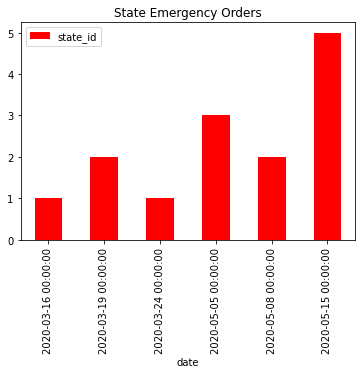

In [51]:
# Generate a bar plot for state orders 
state_orders_group = emergency_orders_data.groupby('date')
measures = pd.DataFrame(state_orders_group['state_id'].count())

state_order_chart=measures.plot(kind='bar', title='State Emergency Orders', color='red')
plt.savefig("/Users/laurelwilliamson/Desktop/GITHUB/group_project/state_orders_vis.png")
plt.show()

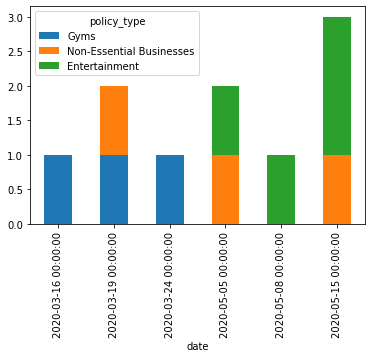

In [52]:
state_order_type = emergency_orders_data.groupby(['date', 'policy_type'])['state_id'].count().unstack('policy_type').fillna(0)
state_order_type[['Gyms','Non-Essential Businesses', 'Entertainment']].plot(kind='bar', stacked=True)
plt.savefig("/Users/laurelwilliamson/Desktop/GITHUB/group_project/policy_shutdowns_vis.png")
plt.show()

In [53]:
#Clean wildfire data to include only incident dates
new_df = wildfire_data.drop('IncidentName', 1)
new_df

,CreateDate
0,2020-07-01
1,2020-07-10
2,2020-07-10
3,2020-06-19
4,2020-07-10
...,...
1663,2020-12-15
1664,2020-12-15
1665,2020-11-17
1666,2020-08-01


In [54]:
#Sort dates and separate info by month
new_df['CreateDate'] = new_df['CreateDate'].apply(str)


#months

Jun = new_df[new_df['CreateDate'].str.contains("2020-06")]
Jul = new_df[new_df['CreateDate'].str.contains("2020-07")]
Augus = new_df[new_df['CreateDate'].str.contains("2020-08")]
Septembe = new_df[new_df['CreateDate'].str.contains("2020-09")]
Octobe = new_df[new_df['CreateDate'].str.contains("2020-10")]
Novembe = new_df[new_df['CreateDate'].str.contains("2020-11")]
Decembe = new_df[new_df['CreateDate'].str.contains("2020-12")]

#Count how many wildfires were recorded per month
June = Jun.shape[0]
July = Jul.shape[0]
August = Augus.shape[0]
September = Septembe.shape[0]
October = Octobe.shape[0]
November = Novembe.shape[0]
December = Decembe.shape[0]

print(June, July, August, September, October, November, December)

184 409 644 230 127 62 12


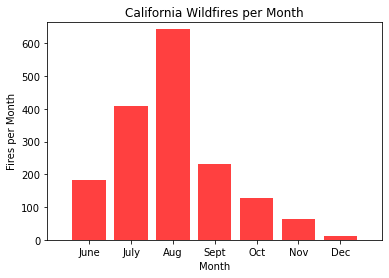

In [55]:
#Plot and save as PNG
months = ["June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
wildfires = [184, 409, 644, 230, 127, 62, 12]

x_axis = np.arange(0, len(months))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)
    
plt.title("California Wildfires per Month")
plt.xlabel("Month")
plt.ylabel("Fires per Month")

plt.xlim(-1, len(months))
plt.ylim(0, max(wildfires) +20)

plt.bar(x_axis, wildfires, facecolor="red", alpha=0.75, align="center")
plt.xticks(tick_locations, months)
#plt.savefig("/Users/laurelwilliamson/Desktop/GITHUB/group_project/califires_vis.png")
plt.show()

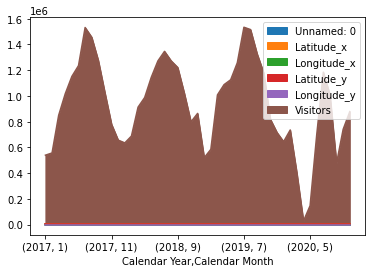

In [56]:
# Limit dataframe to California & Florifa
national_parks = park_info_data.loc[(park_info_data['ParkType']=='National Park')]
focus_parks = pd.DataFrame(national_parks.loc[(park_info_data['State'] == 'CA') | (park_info_data['State'] == 'FL')])
focus_parks.reset_index()

#focus_parks['FullName'] = focus_parks['Park']

# Create new 'FullName' column (empty)
focus_parks['FullName'] = focus_parks['Park'].str.replace(['NP'],'')#+focus_parks['ParkType'])

focus_parks['FullName']=focus_parks['Park'].str[:-2]+focus_parks['ParkType']

#focus_parks['Park'].replace('NP', 'National Park', inplace=True)
#focus_parks['Park'] = focus_parks['Park'].str.replace('NP','')

focus_parks.head(20)

# Find the geocoordinates (latitude and longitude)
park = "Yellowstone"

params = {"address": park, "key": gkey}

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#print("Drill #1: The Geocoordinates of X")

# Run request
response = requests.get(base_url, params=params)

# print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
# print(response.url)

# Convert to JSON
park_geo = response.json()

# Extract lat/lng
lat = park_geo["results"][0]["geometry"]["location"]["lat"]
lng = park_geo["results"][0]["geometry"]["location"]["lng"]


# Build URL using the Google Maps API

lats=[]
longs=[]
cost=[]

base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for Park in focus_parks['FullName']:
    params = {"address": Park, "key": gkey}
    response = requests.get(base_url, params=params)
    park_geo = response.json()
    lats.append(park_geo["results"][0]["geometry"]["location"]["lat"])
    longs.append(park_geo["results"][0]["geometry"]["location"]["lng"])           

# Add geocoordinates to dataframe
focus_parks['Latitude']=lats
focus_parks['Longitude']=longs
focus_parks.head()

# Combine the data into a single dataframe  
park_data = pd.merge(focus_parks, attendance_data, how="left", on=["Park", "Park"])
park_data.head()

park_data['Calendar Year'] = pd.DatetimeIndex(park_data['Month']).year
park_data['Calendar Month'] = pd.DatetimeIndex(park_data['Month']).month
park_data.head(50)

# Split up our data into groups based upon 'bikeid' and 'gender'
year_groups = park_data.groupby(['Calendar Year','Calendar Month'])

# Create a new variable that holds the sum of our groups
sum_it_up = year_groups.sum()
sum_it_up.head(50)

# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the visutors for each calendar year
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 


mean = park_data.groupby('Calendar Month').mean()['Visitors']
median = park_data.groupby('Calendar Month').median()['Visitors']
variance = park_data.groupby('Calendar Month').var()['Visitors']
std_dev = park_data.groupby('Calendar Month').std()['Visitors']
SEM = park_data.groupby('Calendar Month').sem()['Visitors']

# Assemble the resulting series into a single summary dataframe.
park_stats = pd.DataFrame({'Mean': mean,
              'Median':median,
              'Variance': variance,
              'Standard Deviation': std_dev,
                         'SEM':SEM})
park_stats.head(12)

summary_stats= park_data.groupby('Park').agg({'Visitors':['mean','median','var','std','sem']})

sum_it_up.plot.area()
#plt.savefig("/Users/laurelwilliamson/Desktop/GITHUB/group_project/visitor_areaplot_vis.png")
plt.show()